# Urban Heat Island Analysis

#### Importing libraries and setting column width

In [4]:
import os
import json
import requests
import pandas as pd
import numpy as np
from langchain_openai import ChatOpenAI #, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field, create_model
from typing import List, Optional, Text, Dict
from pprint import pprint
from IPython.display import display, Markdown
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, box
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import missingno


In [5]:

import matplotlib
matplotlib.__version__

'3.7.3'

In [6]:
missingno.__version__

'0.4.2'

In [7]:
# importing James custom functions
%load_ext autoreload
%autoreload 2
import os, sys
# sys.path.append(os.path.abspath("../"))
import custom_functions as cf
dir(cf.xml)

['ET',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean_xml_dict',
 'extract_coordinates',
 'label_coordinates',
 'parse_and_clean_xml_file',
 'pd',
 'preview_xml_dict',
 'xml_to_dict']

In [8]:
pd.set_option('display.max_colwidth', 250)

### Grabbing Open AI key

In [9]:
# our OpenAI token
creds_file_open_ai = r"c:/Users/Chris/.secret/open_ai.txt"
with open(creds_file_open_ai) as f:
    creds_open_ai = f.read()

os.environ['OPENAI_API_KEY'] = creds_open_ai

You can access MODIS LST data through various APIs provided by NASA and other institutions. One of the most commonly used APIs is the **NASA Earthdata Search API**. Additionally, you can use the `pyproj` and `sentinelsat` libraries to access and download MODIS data.

### Accessing MODIS LST Data via NASA Earthdata API

To use the NASA Earthdata API, you will need to:

1. **Register for a NASA Earthdata Account:**
   - You need an Earthdata account to access the data. You can register at [Earthdata Login](https://urs.earthdata.nasa.gov/users/new).

2. **Use `pyproj` for Coordinate Transformations:**
   - If needed, you can use `pyproj` to handle coordinate transformations.

3. **Use `sentinelsat` or Other Libraries:**
   - Use libraries like `sentinelsat` for programmatic access to Earth observation data.

Here’s how you can access MODIS LST data using the NASA Earthdata API and the `pyproj` library:

## JMI Addition: Generate a Token
- https://urs.earthdata.nasa.gov/users/jirvingphd/user_tokens 
    - Use "Authorization: Bearer" header.

To use the NASA Earthdata API with a token, you need to generate a token from the NASA Earthdata Login (EDL) and use it in your API requests.

### Step-by-Step Guide

1. **Generate a Token from NASA Earthdata Login:**
   - Log in to your [NASA Earthdata Login](https://urs.earthdata.nasa.gov).
   - Navigate to the "My Profile" section.
   - Generate a new token under the "User Profile" section.

2. **Use the Token in Your API Requests:**
   - Use the generated token in the `Authorization` header of your API requests.

In [10]:
# where we stored the token locally on our PC
creds_json = "./earthdata_creds.json"
with open(creds_json) as f:
    creds = json.load(f)
print(creds.keys())

# Your NASA Earthdata token
token = creds['token']

dict_keys(['token'])


In [11]:
# # Define the search URL and parameters
# search_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
# params = {
#     'short_name': 'MOD11A2',  # MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid
#     'version': '061', 
#     'temporal': '2023-06-01T00:00:00Z,2023-08-31T23:59:59Z',  # Desired temporal range
#     'bounding_box': '-95.5,29.7,-95.0,30.2',  # Bounding box for Houston urban area
#     'page_size': 10,  # Number of results per page
#     'page_num': 1
# }

# # Headers with the token
# headers = {
#     'Authorization': f'Bearer {token}'
# }

# # Send the request
# response = requests.get(search_url, params=params, headers=headers)

# # Check for a successful response
# if response.status_code == 200:
#     data = response.json()
#     print(data)
# else:
#     print(f"Error: {response.status_code} - {response.text}")

In [12]:
# viewing the data we received from the API
# pd.DataFrame(data['feed'])

In [13]:
# entries_df = pd.DataFrame(data['feed']['entry'])
# entries_df.head()

In [14]:
# Extract granule URLs from the search results
# granule_urls = [granule['links'][0]['href'] for granule in data['feed']['entry'] if 'links' in granule and granule['links']]
# granule_urls

## 🤖Using ChatGPT to Set New Coordinates

1. **Sign up for OpenAI's API:** 
   - Visit the [OpenAI website](https://www.openai.com) and sign up for an API key.

2. **Create a `.secret` folder:**
   ```bash
   cd ~
   mkdir .secret
   ```

3. **Save your API key as a text file in the `.secret` folder:**
   - Open a text editor and paste your API key.
   - Save the file as `open-ai.txt` in the `.secret` folder. For example, you can use the following command in the terminal to create the file and save the API key:
   ```bash
   echo "your_openai_api_key_here" > ~/.secret/open-ai.txt
   ```

4. **Export the key from the file to your `.bash_profile`:**
   - Open your `.bash_profile` for editing:
   ```bash
   code ~/.bash_profile
   ```
   - Add the following line to export the API key:
   ```bash
   export OPENAI_API_KEY=$(cat ~/.secret/open-ai.txt)
   ```
   - Save the file and exit the editor 

5. **Reload your `.bash_profile` to apply the changes:**
   ```bash
   source ~/.bash_profile
   ```

After following these steps, your API key will be available in your environment variables as `OPENAI_API_KEY`.

### Using LangChain with ChatGPT

In [15]:
## Defining the structured output desired from chat gpt
## Tip was to use make_model
# https://stackoverflow.com/questions/63257839/best-way-to-specify-nested-dict-with-pydantic
class Coordinates(BaseModel):
    SW: List[float]
    NE: List[float]
    
class RegionCoordinates(BaseModel):
    rural: Optional[Coordinates]
    urban: Optional[Coordinates]
                            
class DataParams(BaseModel):
    """
    Represents the parameters for data analysis.

    Attributes:
        city_region_name (str): The name of the city or region.
        coordinates (Optional[RegionCoordinates]): The coordinates of the city or region.
        time (Dict[str, str]): A dictionary containing time-related information.
    """
    city_region_name: str
    coordinates: Optional[RegionCoordinates]
    time: Dict[str, str]

### Created a function that asks ChatGPT for suggested parameters

In [16]:
def suggest_data_params(query: str, temperature=0.1, model_type='gpt-4o',
                       return_llm = False, return_json=True) -> str:
    """
    Suggests data parameters for downloading MODIS data for a specific region and time range.
    
    Args:
        query (str): The query describing the requirements for the data download.
        temperature (float, optional): The temperature parameter for the language model. Defaults to 0.1.
        model_type (str, optional): The type of language model to use. Defaults to 'gpt-4o'.
        return_llm (bool, optional): Whether to return the language model chain. Defaults to False.
        return_json (bool, optional): Whether to return the response as JSON. Defaults to True.
    
    Returns:
        str: The response from the language model chain or the JSON response, depending on the value of return_json.
    """
    
    # The prompt template for suggesting data parameters
    prompt = """
    I am performing an urban heat island analysis project with MODIS data comparing urban areas vs. rural areas. 
    I need to download MODIS data for 2 nearby non-overlapping regions (urban area and rural area outside of city) and time range.
    Help me select the urban and rural regions and time following the instructions below.
    {query}
    
    Provide me the data parameters for the download (city_region_name, coordinates as SW [lat,long] NE [lat,long], time_start named 'start', time_end named 'end') in the following format:
    Format Instructions:
    {format_instructions}
    """
    # Create a ChatPromptTemplate object
    final_prompt_template = PromptTemplate.from_template(prompt)

    # Get api key for OpenAI from the environment or session state (if on Streamlit)
    try:
        api_key = st.session_state.OPENAI_API_KEY
    except:
        api_key = os.getenv('OPENAI_API_KEY')
        
    # Instantiate the language model and setting the specific model (chat-gpto is newest and reasonable price)
    # and  set the temperature (creativity level)
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    
    if return_json:
        # # JsonOutputParser will use the data model classes from above
        parser = JsonOutputParser(pydantic_object=DataParams,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        ## StrOutputParser will return the response as a string
        parser = StrOutputParser(output_key="response")
        # Manually defining the format instructions
        instructions = "Respond with text for each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
    ## Adding the instructions to the prompt template
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    
    
    # Making the final chain
    llm_chain = final_prompt_template | llm | parser
    
    # Return the chain if specified
    if return_llm:
        return llm_chain
    else:
    
        # Invoke the chain with the query to get the response
        response = llm_chain.invoke(input=dict(query=query))
        return response

In [17]:
GET_NEW_LOCATION = False
# Where we are storing our parameters
fpath_params = "./config/data_params.json"

# If we want a new location
if GET_NEW_LOCATION:
    # ask ChatGPT to suggest another set of parameters
    chatgpt_params = suggest_data_params(query="""Select a region in the southern USA to avoid political bias/spin 
                                        and a time range to highlight the effects of climate change (like 06/01/2023-08/31/2023).
                                        Make sure to select a region that does not cover a body of water.
                                        Select small regions from the selected area to minimize the size of the dataset.
                                        Do not use Texas.""", 
                                        return_json=True, temperature=0.0)


else:
    # otherwise, use the parameters we already have
    with open(fpath_params) as f:
        chatgpt_params = json.load(f)

chatgpt_params

{'city_region_name': 'Atlanta, GA',
 'coordinates': {'urban': {'SW': [33.749, -84.388], 'NE': [33.799, -84.338]},
  'rural': {'SW': [33.5, -84.5], 'NE': [33.55, -84.45]}},
 'time': {'start': '2023-06-01', 'end': '2023-08-31'}}

In [18]:
data_params = chatgpt_params
coordinates = data_params['coordinates']
time_range = data_params['time']

In [19]:
## Save params to disk, but check if file exists first and ask user if they want to overwrite
# Save data params
if GET_NEW_LOCATION == True:

    # Check if file exists
    if os.path.exists(fpath_params):
        with open(fpath_params) as f:
            current = json.load(f)

        # ask user if they want to overwrite what is currently stored in the json file    
        ans = input(f"File {fpath_params} exists.\t\n\nParams: {current}\nOverwrite? (y/n)")
        if ans.lower() == 'n':
            print("Not overwriting file.")
        else:
            print(f"Overwriting file with data params: {chatgpt_params}")
            with open(fpath_params, 'w') as f:
                json.dump(chatgpt_params, f)
    else:
        # save parameters to json file
        print(f"Saving data params to {fpath_params}")
        with open(fpath_params, 'w') as f:
            json.dump(chatgpt_params, f)

## Search and Download Data with Pagination and Return List of Entries/Links

Now that we have the parameters for the locations, we need to ask the NASA Earthdata API for the data  

In [20]:
def search_and_download(region_name, bounding_box, time_range, token, dest_folder='./data/MODIS-LST/',
                        force_download=False, verbose=True):
    """
    Searches for granules using the NASA Earthdata API and downloads the data files for a given region.

    Args:
        region_name (str): The name of the region.
        bounding_box (dict): The bounding box coordinates of the region in the format {'SW': [lat, lon], 'NE': [lat, lon]}.
        time_range (dict): The temporal range of the data in the format {'start': 'YYYY-MM-DD', 'end': 'YYYY-MM-DD'}.
        token (str): The access token for the NASA Earthdata API.
        dest_folder (str, optional): The destination folder to save the downloaded data files. Defaults to './data/MODIS-LST/'.

    Returns:
        list: A list of dictionaries containing the region name and the URL of each downloaded data file.
    """
    # Base URL for searching granules
    search_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
    
    # Pagination settings
    page_size = 10
    page_num = 1
    total_hits = None

    # List to store entries and links
    entries_links = []

    while True:
        # Set up the parameters for the search query
        params = {
            'short_name': 'MOD11A2',  # Dataset short name
            'version': '061',         # Dataset version
            'temporal': f"{time_range['start']},{time_range['end']}",  # Temporal range
            'bounding_box': f"{bounding_box['SW'][1]},{bounding_box['SW'][0]},{bounding_box['NE'][1]},{bounding_box['NE'][0]}",  # Bounding box coordinates
            'page_size': page_size,   # Number of results per page
            'page_num': page_num      # Current page number
        }
        
        # Authorization header with the token
        headers = {
            'Authorization': f'Bearer {token}'
        }

        # Send the request to the NASA Earthdata API
        response = requests.get(search_url, params=params, headers=headers)

        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()


            ## JMI: Confirm this total_hits code works as expected
            # Determine the total number of hits on the first request
            if total_hits is None:
                total_hits = int(response.headers.get('CMR-Hits', 0))
                print(f"Total hits for {region_name}: {total_hits}")

            # Check if there are entries in the response
            if data['feed']['entry']:
                for entry in data['feed']['entry']:
                    # Extract relevant metadata from each entry
                    granule_id = entry.get('id', 'N/A')
                    dataset_id = entry.get('dataset_id', 'N/A')
                    start_time = entry.get('time_start', 'N/A')
                    end_time = entry.get('time_end', 'N/A')
                    spatial_extent = entry.get('boxes', ['N/A'])[0]
                    
                    
                    # Extract the data links for downloading
                    data_links = [link['href'] for link in entry['links'] if 'data#' in link['rel']]
                    
                    # Download each data link and store the entries and links
                    for url in data_links:
                        dir_for_dl = os.path.join(dest_folder, region_name)
                        # Define the filename based on the URL (to check if the file is a directory)
                        filename = os.path.join(dir_for_dl,#dest_folder, 
                                                url.split('/')[-1])
                        
                
                        # Check if directory
                        if os.path.isdir(filename):
                            if verbose:
                                print(f"- Skipping directory {filename}")
                            continue
                        
                        if "s3credentials" in filename:
                            if verbose:
                                print(f"- Skipping S3 credentials link {filename}")
                            continue
                        
                        if '?p' in filename:
                            if verbose:
                                print(f"- Skipping link with query parameters {filename}")
                            continue
                        # Remove question marks
                        filename = filename.replace("?", "-")
                        
                        
                        filepath = download_file(url, dir_for_dl, token, force_download=force_download, 
                                                 verbose=True # Always be verbose for download
                                                 )
                        entries_links.append({'region': region_name, 'url': url,"fpath":filepath, 'granule_id': granule_id, 'dataset_id': dataset_id,
                                            'start_time': start_time, 'end_time': end_time, 'spatial_extent': spatial_extent})
                        # print("\n")
            else:
                print(f"\n[!] No entries found for region: {region_name}")

            # Check if we have fetched all results
            if page_num * page_size >= total_hits:
                break
            else:
                page_num += 1
        else:
            print(f"\n[!] Error: {response.status_code} - {response.text}")
            break

    return entries_links

In [21]:
def download_file(url, dest_folder, token, force_download=False, verbose=True):
    """
    Downloads a file from the given URL and saves it to the specified destination folder.

    Args:
        url (str): The URL of the file to download.
        dest_folder (str): The destination folder where the file will be saved.
        token (str): The authorization token for accessing the file.
        force_download (bool, optional): If set to True, the file will be downloaded even if it already exists in the destination folder. Defaults to False.

    Returns:
        str: The path of the downloaded file.

    Raises:
        None

    """
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Define the filename based on the URL
    filename = os.path.join(dest_folder, url.split('/')[-1])
    
    # Check if the file already exists
    if os.path.exists(filename) and not force_download:
        if verbose:
            print(f"- File {filename} already exists, skipping download.")
        return filename

    # Authorization header with the token
    headers = {
        'Authorization': f'Bearer {token}'
    }
    
    try:
        # Send the request to download the file
        response = requests.get(url, headers=headers)
        
    except Exception as e:
        print(f"- [!] An error occurred while downloading {url}: {e}")
        return
    
    # Save the file if the request is successful
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        if verbose:
            print(f"- Downloaded {filename}")
    else:
        print(f"- [!] Failed to download {url}: {response.status_code}")
    
    return filename

In [22]:
## Plot the region suggested
# Function to generate sample points within a bounding box
def generate_sample_points(sw, ne, num_points=10):
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]
# Dataframe to store results
results = []

# Check if any coordinates within the bounding boxes are over sea
for region, bounds in data_params['coordinates'].items():
    
    sw = bounds['SW']
    ne = bounds['NE']
    
    
    # Generate sample points within the bounding box
    sample_points = generate_sample_points(sw, ne, num_points=10)
    
    for lat, lon in sample_points:
        results.append({'Region': region, 'Latitude': lat, 'Longitude': lon, 'Group': region})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot the results using plotly express
# fig = px.scatter_geo(
#     results_df,
#     lat='Latitude',
#     lon='Longitude',
#     color='Group',
#     symbol='Group',
#     # category_orders={'LandOrSea': ['land', 'sea']},
#     title='Land and Sea Classification of Sample Points within Bounding Boxes',
#     # labels={'LandOrSea': 'Classification'},
#     scope='usa'
# )

fig = px.scatter_mapbox(results_df, lat="Latitude", lon="Longitude", color='Group',
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title="Land and Sea Classification of Sample Points within Bounding Boxes",
                        height=600)

# Add the bounding boxes to the map
for region, bounds in coordinates.items():
    fig.add_trace(
        px.line_geo(
            pd.DataFrame({
                'lat': [bounds['SW'][0], bounds['SW'][0], bounds['NE'][0], bounds['NE'][0], bounds['SW'][0]],
                'lon': [bounds['SW'][1], bounds['NE'][1], bounds['NE'][1], bounds['SW'][1], bounds['SW'][1]]
            }),
            lat='lat',
            lon='lon'
        ).data[0]
    )

# fig.update_geos(
#     visible=False, resolution=50,
#     showcountries=True, countrycolor="Black",
#     showsubunits=True, subunitcolor="Blue"
# )

fig.update_layout(
    height=600,
    # margin={"r":0,"t":0,"l":0,"b":0}
)

fig.show()

In [23]:
# Set DATA_DIR using region name from data params
DATA_DIR = f"./data/MODIS-LST/{data_params['city_region_name'].replace(',','_').replace(' ','')}/"
DATA_DIR

'./data/MODIS-LST/Atlanta_GA/'

This code will search for and download MODIS LST data for the specified area and time period, storing the data files in the specified directory.

In [24]:
# List to store all entries and links
all_entries_links = []

# Iterate through the regions and download data
for region_name, bounding_box in data_params['coordinates'].items():
    time_range = data_params['time']
    # group_links=  []
    entries_links = search_and_download(region_name, bounding_box, time_range, token=creds['token'],
                                        dest_folder=DATA_DIR, force_download=False, 
                                        verbose=False # new verbose flag
                                        )
    all_entries_links.extend(entries_links)
    print('\n\n')

Total hits for urban: 13
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.061 already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.061 already exists, skipping download.
- File ./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2

### Explanation

1. **Define Coordinates and Time Range:**
   - `coordinates`: Dictionary containing bounding box coordinates for each region.
   - `time_range`: Dictionary containing the start and end times for the data search in a flexible format.
   - Use `pd.to_datetime` to convert the flexible date format to the required format (`'%Y-%m-%dT%H:%M:%SZ'`) for the API call.

2. **Search and Download Data with Pagination and Return List of Entries/Links:**
   - **`search_and_download` function:**
     - **Parameters:** `region_name`, `bounding_box`, `time_range`, `dest_folder`, `token`.
     - Constructs the search URL and parameters with the correct time format.
     - Sends the GET request with authorization.
     - Parses the JSON response.
     - Handles pagination to retrieve all pages of results.
     - Downloads data files for each granule entry.
     - Stores the entries and links in a list and returns the list.
   
   - **`download_file` function:**
     - **Parameters:** `url`, `dest_folder`, `token`.
     - Creates the destination folder if it doesn't exist.
     - Downloads the file from the URL with authorization.
     - Saves the file to the specified folder.
   
   - **Main Loop:**
     - Iterates through each region in the `coordinates` dictionary.
     - Calls `search_and_download` for each region to download the data.
     - Collects all entries and links in a list.
   
   - **Save to CSV:**
     - Converts the list of entries and links to a pandas DataFrame.
     - Saves the DataFrame to a CSV file.

By following this approach, you can keep track of which region the data belongs to and save the entries and links to a CSV file for further analysis or reference.

### Saving Files into a Dataframe

In [25]:
# putting files into a dataframe
files_df = pd.DataFrame(all_entries_links)

# Save the data to a CSV file
fpath_all_files_csv = "./data/MODIS-LST/all_files_df.csv"
files_df.to_csv(fpath_all_files_csv,index=False)
pd.read_csv(fpath_all_files_csv).head()

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
2,urban,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
3,urban,https://doi.org/10.5067/MODIS/MOD11A2.061,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.061,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,NaN
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,NaN


The code below separates the 

In [26]:
# saving both hdf and xml files
files_df = files_df[files_df['fpath'].str.endswith('.hdf')|files_df['fpath'].str.endswith('.xml')].copy()
# grabbing the end of the filepath and putting in new column
files_df['type'] = files_df['fpath'].apply(lambda x: x.split('.')[-1])

# Save to csv
fpath_files_df_csv = "./data/MODIS-LST/files_df.csv"
files_df.to_csv(fpath_files_df_csv, index=False)
files_df.head()

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
2,urban,s3://lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,hdf
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,xml


In [27]:
# storing hdf and xml files in their own dataset
# xml_files = files_df.loc[files_df['type'] == 'xml'].drop(columns=['url'])
# hdf_files = files_df.loc[files_df['type'] == 'hdf'].drop(columns=['url'])

### Using Xarray on the first row of the dataset

In [28]:
# grabbing one ropw of the dataset to test on
hdf_and_xml_fpath = files_df.iloc[0]['fpath']

# Load in example dataset
dataset = xr.open_dataset(hdf_and_xml_fpath, engine='netcdf4')
[i for i in dir(dataset) if not i.startswith('_')]
# dataset
print(dataset)

<xarray.Dataset>
Dimensions:           (YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Dimensions without coordinates: YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Day            (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_time     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_angl     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    LST_Night_1km     (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Night          (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Night_view_time   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Night_view_angl   (YDim:MODIS_Grid_8Day_1km_LST, XDim:MOD

In [29]:
# Remove duplicate files
files_df = files_df.drop_duplicates(subset=['fpath'])

files_df.head(4)

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,hdf
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,xml


## Processing and Cleaning .xml files with James

In [30]:
def remove_extension(fpath):
    return fpath.replace('.cmr.xml','').replace('.hdf','')

files_df['fname'] = files_df['fpath'].apply(remove_extension)
files_df

,region,url,fpath,granule_id,dataset_id,start_time,end_time,spatial_extent,type,fname
0,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129
1,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023145.h11v05.061.2023154043129/MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129
4,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254
5,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023153.h11v05.061.2023164034254/MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254
8,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023161.h11v05.061.2023170175014/MOD11A2.A2023161.h11v05.061.2023170175014.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.hdf,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014
9,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023161.h11v05.061.2023170175014/MOD11A2.A2023161.h11v05.061.2023170175014.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.cmr.xml,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014
12,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023169.h11v05.061.2023178033141/MOD11A2.A2023169.h11v05.061.2023178033141.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.hdf,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141
13,urban,https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD11A2.061/MOD11A2.A2023169.h11v05.061.2023178033141/MOD11A2.A2023169.h11v05.061.2023178033141.cmr.xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.cmr.xml,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,xml,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.202317

In [31]:

# fpath = file_list_dict['rural'][0]
# fpath

In [32]:
# Group Files by fname stub (without extension)
# grouped_files = files.groupby('fname')['fpath'].apply(lambda x: x.values)
grouped_files = files_df.groupby('fname')['fpath'].apply(lambda x: ";".join(x))#.values)
grouped_files = grouped_files.to_frame('fpaths_combined')#.reset_index()
grouped_files

,fpaths_combined
fname,
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427.cmr.xml
./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112.hdf;./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112.cmr.xml


In [33]:
grouped_files[['.hdf_file','.xml_file']] = grouped_files['fpaths_combined'].str.split(";", expand=True)
grouped_files = grouped_files.drop(columns=['fpaths_combined']).reset_index()
grouped_files

,fname,.hdf_file,.xml_file
0,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023145.h10v05.061.2023154043348.cmr.xml
1,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023153.h10v05.061.2023164034945.cmr.xml
2,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023161.h10v05.061.2023170174955.cmr.xml
3,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023169.h10v05.061.2023178032855.cmr.xml
4,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023177.h10v05.061.2023191230902.cmr.xml
5,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023185.h10v05.061.2023201061108.cmr.xml
6,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023193.h10v05.061.2023214105100.cmr.xml
7,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023201.h10v05.061.2023215144427.cmr.xml
8,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023209.h10v05.061.2023220023112.cmr.xml
9,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023217.h10v05.061.2023226040536,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023217.h10v05.061.2023226040536.hdf,./data/MODIS-LST/Atlanta_GA/rural\MOD11A2.A2023217.h10v05.061.2023226040536.cmr.xml


In [34]:
file_cols = files_df.drop(columns=['url','type','fpath'], errors='ignore').columns # ['region','fname','fpath','']
hdf_files_df = files_df.loc[files_df['type']=='hdf', file_cols]
hdf_files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,fname
0,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129
4,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254
8,urban,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014
12,urban,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141
16,urban,G2730480830-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-26T00:00:00.000Z,2023-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430


In [35]:
files_df = pd.merge(hdf_files_df,grouped_files, on='fname', how='left')
files_df = files_df.set_index('fname')
files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file
fname,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014,urban,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141,urban,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430,urban,G2730480830-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-26T00:00:00.000Z,2023-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.cmr.xml


In [36]:
xml_df = files_df['.xml_file'].apply(cf.xml.parse_and_clean_xml_file, as_series=True)
xml_df.head()

,GranuleUR,InsertTime,LastUpdate,DataFormat,Collection__ShortName,Collection__VersionId,PGEVersionClass__PGEVersion,DataGranule__SizeMBDataGranule,DataGranule__ReprocessingPlanned,DataGranule__ReprocessingActual,...,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE
fname,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,2023-06-02T23:36:49.338Z,HDF-EOS2,MOD11A2,061,6.4.4,5.54325,further update is anticipated,reprocessed,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,2023-06-12T23:41:46.196Z,HDF-EOS2,MOD11A2,061,6.4.4,5.31298,further update is anticipated,reprocessed,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014,MOD11A2.A2023161.h11v05.061.2023170175014,2023-06-19T13:21:10.769Z,2023-06-19T13:21:43.583Z,HDF-EOS2,MOD11A2,061,6.4.4,5.56658,further update is anticipated,reprocessed,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141,MOD11A2.A2023169.h11v05.061.2023178033141,2023-06-26T22:45:01.078Z,2023-06-26T22:45:33.275Z,HDF-EOS2,MOD11A2,061,6.4.4,4.90056,further update is anticipated,reprocessed,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430,MOD11A2.A2023177.h11v05.061.2023191225430,2023-07-10T18:24:25.273Z,2023-07-10T18:24:58.372Z,HDF-EOS2,MOD11A2,061,6.4.4,5.29431,further update is anticipated,reprocessed,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"


In [37]:
files_df_with_xml = pd.concat([files_df, xml_df], axis=1)
files_df_with_xml.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file,GranuleUR,InsertTime,...,AddlAttr__CLOUD_CONTAMINATED_LST_SCREENED,AddlAttr__HORIZONTALTILENUMBER,AddlAttr__VERTICALTILENUMBER,AddlAttr__TileID,AddlAttr__identifier_product_doi,AddlAttr__identifier_product_doi_authority,Spatial_Coordinates__SW,Spatial_Coordinates__SE,Spatial_Coordinates__NW,Spatial_Coordinates__NE
fname,,,,,,,,,,,,,,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml,MOD11A2.A2023145.h11v05.061.2023154043129,2023-06-02T23:36:16.534Z,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml,MOD11A2.A2023153.h11v05.061.2023164034254,2023-06-12T23:41:05.264Z,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014,urban,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.cmr.xml,MOD11A2.A2023161.h11v05.061.2023170175014,2023-06-19T13:21:10.769Z,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141,urban,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.cmr.xml,MOD11A2.A2023169.h11v05.061.2023178033141,2023-06-26T22:45:01.078Z,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430,urban,G2730480830-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-26T00:00:00.000Z,2023-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.cmr.xml,MOD11A2.A2023177.h11v05.061.2023191225430,2023-07-10T18:24:25.273Z,...,NO,11,05,51011005,10.5067/MODIS/MOD11A2.061,https://doi.org,"(30.0041666666667, -80.8406302319072)","(30.0041666666667, -69.2926738917516)","(39.9958333333333, -91.3839397474365)","(39.9958333333333, -78.329888184268)"


In [38]:
files_df_with_xml.to_csv("./data/MODIS-LST/files_with_xml_data.csv")

### Checking to make sure Coordinates are on land

To determine whether your coordinates are over land or sea, you can use a geographic information system (GIS) library like `geopandas` along with a shapefile that contains land and sea boundaries. One such dataset is the Natural Earth dataset, which provides vector data for land and water boundaries.

Here’s how you can achieve this using Python:

1. **Install the required libraries:**
   - `geopandas`: For handling geographic data.
   - `shapely`: For geometric operations.

2. **Download the Natural Earth dataset:**
   - You can download the Natural Earth land polygons dataset from [Natural Earth](https://www.naturalearthdata.com/downloads/110m-physical-vectors/).

3. **Load the shapefile and check the coordinates:**

In [39]:
# Load the Natural Earth land polygons shapefile (see above link to download data)
land_shapefile = "./data/110m_physical/ne_110m_land.shp" #"path/to/ne_110m_land.shp"
land = gpd.read_file(land_shapefile, engine='fiona')
land

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.54966, -60.15966 -81.00033, -62.25539 -80.86318, -64.48813 -80.92193, -65.74167 -80.58883, -65.74167 -80.54966, -66.29003 -80.25577, -64.03769 -80.29494, -61.88325 -80.39287, -61.13898 -79.98137, -60.6..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79.63421, -162.43985 -79.28147, -163.02741 -78.92877, -163.0666 -78.86997, -163.7129 -78.59567, -163.7129 -78.59567, -163.1058 -78.22334, -161.24511 -78.38018, -160.24621 -78.69365, -159.4824 -79.04634, ..."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4781, -43.48995 -79.08556, -43.37244 -79.51664, -43.33327 -80.02612, -44.88054 -80.33964, -46.50617 -80.59436, -48.38642 -80.82948, -50.48211 -81.02544, -52.85199 -80.96669, -54.16426 -80.63353, -53.98..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73.65773, -118.72414 -73.48135, -119.29212 -73.8341, -120.23222 -74.08881, -121.62283 -74.01047, -122.62173 -73.65778, -122.62174 -73.65778, -122.40624 -73.32462, -121.21151 -73.50099))"
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73.87327, -124.61947 -73.8341, -125.91218 -73.73612, -127.28313 -73.46177, -127.28313 -73.46177, -126.55847 -73.24623, -125.55957 -73.48135))"
...,...,...,...,...
122,Land,1,1.0,"POLYGON ((51.13619 80.54728, 49.79368 80.41543, 48.89441 80.33957, 48.75494 80.17547, 47.58612 80.01018, 46.50283 80.24725, 47.07246 80.55942, 44.84696 80.58981, 46.79914 80.77192, 48.31848 80.78401, 48.52281 80.51457, 49.09719 80.75399, 50.03977..."
123,Land,0,0.0,"POLYGON ((99.93976 78.88094, 97.75794 78.7562, 94.97259 79.04475, 93.31288 79.4265, 92.5454 80.14379, 91.18107 80.34146, 93.77766 81.0246, 95.9409 81.2504, 97.88385 80.74698, 100.18666 79.78014, 99.93976 78.88094))"
124,Land,0,0.0,"POLYGON ((-87.02 79.66, -85.81435 79.3369, -87.18756 79.0393, -89.03535 78.28723, -90.80436 78.21533, -92.87669 78.34333, -93.95116 78.75099, -93.93574 79.11373, -93.14524 79.3801, -94.974 79.37248, -96.07614 79.70502, -96.70972 80.15777, -96.016..."
125,Land,0,0.0,"POLYGON ((-68.5 83.10632, -65.82735 83.02801, -63.68 82.9, -61.85 82.6286, -61.89388 82.36165, -64.334 81.92775, -66.75342 81.72527, -67.65755 81.50141, -65.48031 81.50657, -67.84 80.9, -69.4697 80.61683, -71.18 79.8, -73.2428 79.63415, -73.88 79..."


In [40]:
# Function to check if a coordinate is over land
def is_land(lat, lon, land_gdf):
    point = Point(lon, lat)
    return any(land_gdf.contains(point))

In [41]:

# Function to generate sample points within a bounding box
def generate_sample_points(sw, ne, num_points=10):
    latitudes = [sw[0] + i * (ne[0] - sw[0]) / (num_points - 1) for i in range(num_points)]
    longitudes = [sw[1] + i * (ne[1] - sw[1]) / (num_points - 1) for i in range(num_points)]
    return [(lat, lon) for lat in latitudes for lon in longitudes]

Looping through all the regions and bounds within our coordinates to identify how many points are over land and sea (should all be over land)

In [42]:
# # Define your coordinates
# coordinates = {
#     'urban': {"SW": [29.5, -95.5], "NE": [30.0, -95.0]},
#     'rural': {"SW": [30.5, -96.5], "NE": [31.0, -96.0]},
# }

# Check if any coordinates within the bounding boxes are over sea
# coordinates variable comes from: data_params['coordinates']
for region, bounds in coordinates.items():
    sw = bounds['SW']
    ne = bounds['NE']
    
    # Generate sample points within the bounding box
    sample_points = generate_sample_points(sw, ne, num_points=100)
    
    sea_points = []
    land_points = []
    for lat, lon in sample_points:
        if is_land(lat, lon, land):
            land_points.append((lat, lon))
        else:
            sea_points.append((lat, lon))
    
    if sea_points:
        print(f"Region: {region} has points over the sea.")
    else:
        print(f"Region: {region} is entirely over land.")
    
    
    # Print details
    print(f"Number of land points: {len(land_points)}")
    print(f"Number of sea points: {len(sea_points)}")

Region: urban is entirely over land.
Number of land points: 10000
Number of sea points: 0
Region: rural is entirely over land.
Number of land points: 10000
Number of sea points: 0


In [43]:
files_df.head()

,region,granule_id,dataset_id,start_time,end_time,spatial_extent,.hdf_file,.xml_file
fname,,,,,,,,
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129,urban,G2704231484-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-05-25T00:00:00.000Z,2023-06-01T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023145.h11v05.061.2023154043129.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254,urban,G2709346843-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-02T00:00:00.000Z,2023-06-09T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023153.h11v05.061.2023164034254.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014,urban,G2715603187-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-10T00:00:00.000Z,2023-06-17T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023161.h11v05.061.2023170175014.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141,urban,G2720722874-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-18T00:00:00.000Z,2023-06-25T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023169.h11v05.061.2023178033141.cmr.xml
./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430,urban,G2730480830-LPCLOUD,MODIS/Terra Land Surface Temperature/Emissivity 8-Day L3 Global 1km SIN Grid V061,2023-06-26T00:00:00.000Z,2023-07-03T23:59:59.000Z,N/A,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.hdf,./data/MODIS-LST/Atlanta_GA/urban\MOD11A2.A2023177.h11v05.061.2023191225430.cmr.xml


In [44]:
USE_DICT= True
file_list_dict = files_df.groupby('region')['.hdf_file'].apply(list).to_dict()

shape_list = []

if USE_DICT:
    # Loop to load all files
    dataset_dict = {'urban':[],
                    'rural':[]}
else:
    dataset_list = []

for group, file_list in file_list_dict.items():
    for fpath in file_list:
        # Open the HDF5 file
    
        dataset = xr.open_dataset(fpath, engine='netcdf4')
    
        # Save the group as an attribute
        dataset = dataset.expand_dims(group=[group])
        
        shape_list.append([group, dataset['LST_Day_1km'].shape])
        # dataset.attrs['group'] = group
        
        
        
        if USE_DICT:
            dataset_dict[group].append(dataset)
        else:
            dataset_list.append(dataset)
        

if USE_DICT:
    print(f'- Using dictionary')
    # Combine all the datasets into a single dataset
    ds_rural = xr.concat(dataset_dict['rural'], dim='time')
    ds_urban = xr.concat(dataset_dict['urban'], dim='time')
    
    # Combined dataset (added back)
    ds = xr.concat([ds_rural, ds_urban], dim='time')

else:
    print(f'- Using list')
    ds = xr.concat(dataset_list, dim='time')

print(ds)

- Using dictionary


c:\Users\Chris\anaconda3\envs\nasa-env\Lib\site-packages\xarray\core\concat.py:544: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

c:\Users\Chris\anaconda3\envs\nasa-env\Lib\site-packages\xarray\core\concat.py:544: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



<xarray.Dataset>
Dimensions:           (group: 2, time: 26, YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * group             (group) object 'rural' 'urban'
Dimensions without coordinates: time, YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables:
    LST_Day_1km       (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Day            (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_time     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_angl     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    LST_Night_1km     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Night          (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST

In [45]:
## CONVERT THE TEMPERATURE FROM KELVIN TO CELSIUS AND FAHRENHEIT
def convert_temp_in_array(dataset, verbose=True):
    
    # Convert LST from Kelvin to Celsius
    lst_celsius = dataset['LST_Day_1km']-273.15#* 0.02 - 273.15

    # Convert LST from Celsius to Fahrenheit
    lst_fahrenheit = (lst_celsius * 9 / 5) + 32

    # Add these new variables to the dataset
    dataset['LST_Day_1km_C'] = lst_celsius #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_celsius.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_C'].attrs['units'] = 'Celsius'
    dataset['LST_Day_1km_C'].attrs['description'] = 'Land Surface Temperature in Celsius'


    # Add these new variables to the dataset
    dataset['LST_Day_1km_F'] = lst_fahrenheit #(('time', 'YDim:MODIS_Grid_8Day_1km_LST', 'XDim:MODIS_Grid_8Day_1km_LST'), lst_fahrenheit.data)
    # Add attributes to the new variables
    dataset['LST_Day_1km_F'].attrs['units'] = 'Fahrenheit'
    dataset['LST_Day_1km_F'].attrs['description'] = 'Land Surface Temperature in Fahrenheit'

    if verbose:
        # Inspect the updated dataset
        print("Updated Dataset:\n", dataset)

    return dataset


ds_rural = convert_temp_in_array(ds_rural)
ds_urban = convert_temp_in_array(ds_urban)

Updated Dataset:
 <xarray.Dataset>
Dimensions:           (group: 1, time: 13, YDim:MODIS_Grid_8Day_1km_LST: 1200,
                       XDim:MODIS_Grid_8Day_1km_LST: 1200)
Coordinates:
  * group             (group) object 'rural'
Dimensions without coordinates: time, YDim:MODIS_Grid_8Day_1km_LST,
                                XDim:MODIS_Grid_8Day_1km_LST
Data variables: (12/14)
    LST_Day_1km       (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Day            (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_time     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_angl     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    LST_Night_1km     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Night          (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS

In [46]:
from pprint import pprint
coordinates = data_params['coordinates']
time = data_params['time']

pprint(f"{coordinates=}")
pprint(f"{time=}")

("coordinates={'urban': {'SW': [33.749, -84.388], 'NE': [33.799, -84.338]}, "
 "'rural': {'SW': [33.5, -84.5], 'NE': [33.55, -84.45]}}")
"time={'start': '2023-06-01', 'end': '2023-08-31'}"


In [47]:
lat_lons = {}

for group, bounds in coordinates.items():
    
    # Create a bounding box
    latitutes = [bounds['SW'][0], bounds['NE'][0]]
    longitudes = [bounds['SW'][1], bounds['NE'][1]]
    lat_lons[group] = {'lat': latitutes, 'lon': longitudes}
    
    # bbox = box(*bounds['SW'], *bounds['NE'])
    # lat_lons[group]['box'] = bbox
    
    # x_array = np.linspace(*longitudes, ds.sel(group=group).sizes['XDim:MODIS_Grid_8Day_1km_LST'])
    # y_array = np.linspace(*latitutes, ds.sel(group=group).sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    
    # lat_lons[group]['x'] = x_array
    # lat_lons[group]['y'] = y_array
    
lat_lons

{'urban': {'lat': [33.749, 33.799], 'lon': [-84.388, -84.338]},
 'rural': {'lat': [33.5, 33.55], 'lon': [-84.5, -84.45]}}

In [48]:
def save_coordinates(ds, lat1,lat2, lon1, lon2):
    ## Define the latitude and longitude ranges based on the MODIS tile
    latitudes = np.linspace(lat1, lat2, ds.sizes['YDim:MODIS_Grid_8Day_1km_LST'])
    longitudes = np.linspace(lon1, lon2, ds.sizes['XDim:MODIS_Grid_8Day_1km_LST'])

    # Add latitude and longitude as coordinates
    ds = ds.assign_coords(lat=('YDim:MODIS_Grid_8Day_1km_LST', latitudes))
    ds = ds.assign_coords(lon=('XDim:MODIS_Grid_8Day_1km_LST', longitudes))
    
    return ds

ds_rural = save_coordinates(ds_rural, *lat_lons['rural']['lat'], *lat_lons['rural']['lon'])
ds_urban = save_coordinates(ds_urban, *lat_lons['urban']['lat'], *lat_lons['urban']['lon'])

### Chris creating loop to see percent of null values in each col

In [49]:
i_sel = 1
df_rural = ds_rural['LST_Day_1km'].isel(time=i_sel).to_dataframe().reset_index()
df_urban = ds_urban['LST_Day_1km'].isel(time=i_sel).to_dataframe().reset_index()

In [50]:
def check_for_nans(df):
    # list of column names from the dataset
    ds_variable_columns = list(df.keys())
    # empty list that we will store dictionaries in
    all_time = []
    # empty list that we will store dataframes in
    all_time_df = []

    for i in range(df.sizes['time']):
        test_dict = {}
        for col in ds_variable_columns:
            loop_df = df[col].isel(time=i).to_dataframe().reset_index()
            temp_dict = {'Mean' : round(loop_df[col].isna().mean(), 4), 
                        'Sum': loop_df[col].isna().sum()}
            test_dict[col] = temp_dict
        all_time.append(test_dict)

    # transforming the dictionaries we created into dataframes and storing them into a list
    for i, test_dict in enumerate(all_time):
        temp_df = pd.DataFrame(test_dict)
        temp_df = temp_df.loc['Mean']
        temp_df.name = f"Time_{i+1}"
        all_time_df.append(temp_df)

    return pd.concat(all_time_df, axis=1)

In [51]:
i = 0
loop_df = ds_urban['LST_Day_1km_F'].isel(time=i).to_dataframe().reset_index()
loop_df

,group,YDim:MODIS_Grid_8Day_1km_LST,XDim:MODIS_Grid_8Day_1km_LST,lat,lon,LST_Day_1km_F
0,urban,0,0,33.749,-84.388000,94.945999
1,urban,0,1,33.749,-84.387958,95.810020
2,urban,0,2,33.749,-84.387917,95.918015
3,urban,0,3,33.749,-84.387875,94.369987
4,urban,0,4,33.749,-84.387833,94.838005
...,...,...,...,...,...,...
1439995,urban,1199,1195,33.799,-84.338167,NaN
1439996,urban,1199,1196,33.799,-84.338125,NaN
1439997,urban,1199,1197,33.799,-84.338083,NaN
1439998,urban,1199,1198,33.799,-84.338042,NaN


<Axes: >

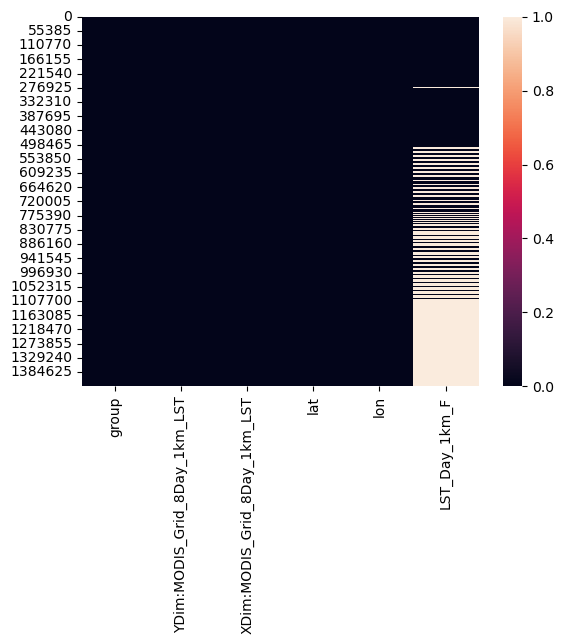

In [53]:
# missingno.matrix(loop_df)
sns.heatmap(loop_df.isna())

In [62]:
i_sel = 0
df_rural = ds_rural.isel(time=i_sel).to_dataframe().reset_index()
df_urban = ds_urban.isel(time=i_sel).to_dataframe().reset_index()

df = pd.concat([df_rural, df_urban])
df

,group,YDim:MODIS_Grid_8Day_1km_LST,XDim:MODIS_Grid_8Day_1km_LST,LST_Day_1km,QC_Day,Day_view_time,Day_view_angl,LST_Night_1km,QC_Night,Night_view_time,Night_view_angl,Emis_31,Emis_32,Clear_sky_days,Clear_sky_nights,LST_Day_1km_C,LST_Day_1km_F,lat,lon
0,rural,0,0,300.019989,0.0,10.400001,-12.0,285.359985,65.0,21.300001,-26.0,0.984,0.986,255.0,48.0,26.869995,80.365990,33.500,-84.500000
1,rural,0,1,300.119995,0.0,10.600000,3.0,285.139984,65.0,21.700001,11.0,0.984,0.986,255.0,16.0,26.970001,80.546005,33.500,-84.499958
2,rural,0,2,300.600006,0.0,10.600000,3.0,284.880005,65.0,22.000000,29.0,0.984,0.986,255.0,144.0,27.450012,81.410019,33.500,-84.499917
3,rural,0,3,301.339996,0.0,10.600000,3.0,284.100006,65.0,21.800001,13.0,0.984,0.988,255.0,208.0,28.190002,82.742004,33.500,-84.499875
4,rural,0,4,301.320007,0.0,10.600000,3.0,284.380005,65.0,21.800001,13.0,0.984,0.986,255.0,208.0,28.170013,82.706024,33.500,-84.499833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,urban,1199,1195,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.799,-84.338167
1439996,urban,1199,1196,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.799,-84.338125
1439997,urban,1199,1197,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.799,-84.338083
1439998,urban,1199,1198,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.799,-84.338042


In [68]:
# all values
df['QC_Day'].value_counts(dropna=False).sort_index()

QC_Day
0.0      1723206
2.0        90804
3.0       606475
17.0        1998
65.0      437781
81.0       18202
97.0           1
129.0         49
145.0       1484
Name: count, dtype: int64

In [70]:
# QC for all rows that have null values
df[df['LST_Night_1km'].isna()]['QC_Day'].value_counts(dropna=False).sort_index()

QC_Day
0.0       53033
2.0        5811
3.0      606475
17.0        253
65.0      15415
81.0       3518
129.0         1
145.0       229
Name: count, dtype: int64

In [66]:
# QC for all rows that have no null values
df[df['LST_Night_1km'].notnull()]['QC_Day'].value_counts(dropna=False)

QC_Day
0.0      1670173
65.0      422366
2.0        84993
81.0       14684
17.0        1745
145.0       1255
129.0         48
97.0           1
Name: count, dtype: int64

In [78]:
# checking QC control versus null values
df['is_null'] = df['LST_Day_1km'].isna()
# creating new col that identifies if the value of QC_Day is 2 or 3
df['is_2_or_3'] = df['QC_Day'].isin([2.0, 3.0])
# confirming that all null values in LST_Day_1km are associated with either 2 or 3 in teh QC_Day col
(df['is_null'] == df['is_2_or_3']).all()

True

In [77]:
df.groupby('is_null', as_index=False)['QC_Day'].unique()#.value_counts(dropna=False)

,is_null,QC_Day
0,False,"[0.0, 65.0, 81.0, 17.0, 145.0, 129.0, 97.0]"
1,True,"[2.0, 3.0]"


<Axes: >

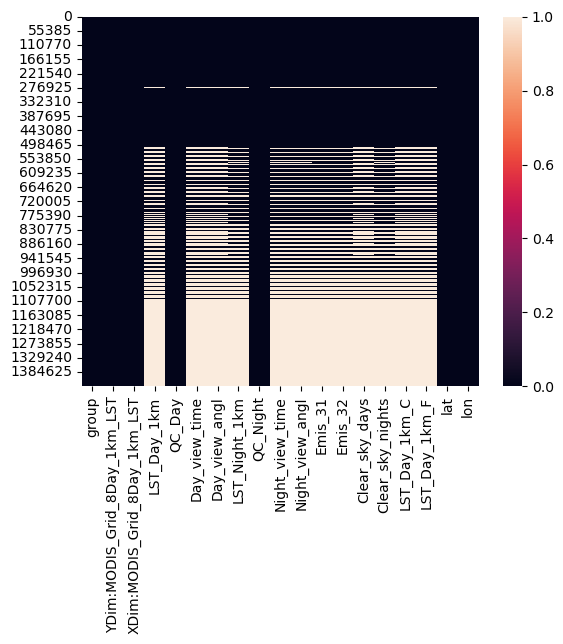

In [61]:
sns.heatmap(df_urban.isna())

### QC_Day == 2 or 3 indicates Null values. We need to figure out why, and what those numbers actually mean

The Quality Control (QC) flags in MODIS data, specifically QC_Day, have several bit flags that indicate different aspects of the data quality. According to the MODIS user guide, the meanings of QC_Day values 2 and 3 are as follows:

- **QC_Day = 2**: This indicates that the land surface temperature (LST) was not produced due to cloud effects.
- **QC_Day = 3**: This indicates that the LST was not produced primarily due to reasons other than clouds, such as an ocean grid or a grid not covered by all processed granules .

These values can help you understand why certain data points might be missing or marked as NaN (Not a Number). If your dataset has a high number of these QC_Day values, it suggests that a significant portion of the area was either cloud-covered or had other issues preventing LST measurement. This could explain why one dataset has significantly more NaN values compared to another. (From ChatGPT)

In [79]:
# checking QC control versus null values
df['is_null_night'] = df['LST_Night_1km'].isna()
# creating new col that identifies if the value of QC_Day is 2 or 3
df['is_2_or_3_night'] = df['QC_Night'].isin([2.0, 3.0])
# confirming that all null values in LST_Day_1km are associated with either 2 or 3 in teh QC_Day col
(df['is_null_night'] == df['is_2_or_3_night']).all()

True

In [111]:
urban_nans_df = check_for_nans(ds_urban)
rural_nans_df = check_for_nans(ds_rural)

In [118]:
urban_nans_df.style.background_gradient(vmin=0, vmax=0.5)

,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,Time_10,Time_11,Time_12,Time_13
LST_Day_1km,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
QC_Day,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Day_view_time,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
Day_view_angl,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
LST_Night_1km,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
QC_Night,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Night_view_time,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
Night_view_angl,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
Emis_31,0.408400,0.405000,0.405000,0.405100,0.408700,0.405300,0.405000,0.405100,0.406000,0.405200,0.405000,0.405000,0.404900
Emis_32,0.408400,0.405000,0.405000,0.405100,0.408700,0.405300,0.405000,0.405100,0.406000,0.405200,0.405000,0.405000,0.404900


In [119]:
rural_nans_df.style.background_gradient(vmin=0, vmax=0.5)

,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,Time_10,Time_11,Time_12,Time_13
LST_Day_1km,0.023800,0.016600,0.031700,0.019700,0.016500,0.042000,0.027000,0.016500,0.018400,0.049000,0.016400,0.016400,0.018500
QC_Day,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Day_view_time,0.023800,0.016600,0.031700,0.019700,0.016500,0.042000,0.027000,0.016500,0.018400,0.049000,0.016400,0.016400,0.018500
Day_view_angl,0.023800,0.016600,0.031700,0.019700,0.016500,0.042000,0.027000,0.016500,0.018400,0.049000,0.016400,0.016400,0.018500
LST_Night_1km,0.055300,0.054700,0.068900,0.020700,0.016400,0.084900,0.033500,0.017900,0.025000,0.031300,0.016600,0.016400,0.034500
QC_Night,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Night_view_time,0.055300,0.054700,0.068900,0.020700,0.016400,0.084900,0.033500,0.017900,0.025000,0.031300,0.016600,0.016400,0.034500
Night_view_angl,0.055300,0.054700,0.068900,0.020700,0.016400,0.084900,0.033500,0.017900,0.025000,0.031300,0.016600,0.016400,0.034500
Emis_31,0.016800,0.016400,0.019200,0.016400,0.016300,0.018500,0.016700,0.016300,0.016800,0.016500,0.016300,0.016300,0.016600
Emis_32,0.016800,0.016400,0.019200,0.016400,0.016300,0.018500,0.016700,0.016300,0.016800,0.016500,0.016300,0.016300,0.016600


### Investigating null values

In [81]:
nans_df.style.bar()

,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,Time_10,Time_11,Time_12,Time_13
LST_Day_1km,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
QC_Day,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Day_view_time,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
Day_view_angl,0.460500,0.405100,0.406900,0.437300,0.433100,0.410500,0.407800,0.405600,0.409600,0.444000,0.405000,0.405400,0.405100
LST_Night_1km,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
QC_Night,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Night_view_time,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
Night_view_angl,0.420200,0.407100,0.407500,0.414900,0.462300,0.428500,0.406800,0.418200,0.425100,0.411100,0.409900,0.406100,0.405300
Emis_31,0.408400,0.405000,0.405000,0.405100,0.408700,0.405300,0.405000,0.405100,0.406000,0.405200,0.405000,0.405000,0.404900
Emis_32,0.408400,0.405000,0.405000,0.405100,0.408700,0.405300,0.405000,0.405100,0.406000,0.405200,0.405000,0.405000,0.404900


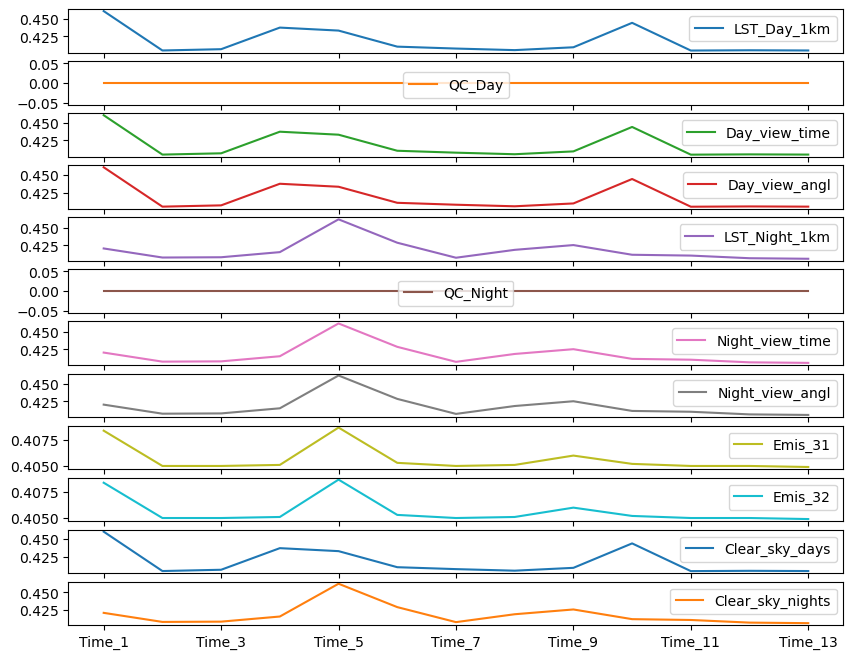

In [93]:
ax = nans_df.T.plot(subplots=True, figsize=(10,8))
# ax.legend(bbox_to_anchor=[1, 1]);

In [56]:
ds_urban.data_vars

Data variables:
    LST_Day_1km       (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Day            (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_time     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Day_view_angl     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    LST_Night_1km     (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    QC_Night          (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Night_view_time   (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Night_view_angl   (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Emis_31           (time, group, YDim:MODIS_Grid_8Day_1km_LST, XDim:MODIS_Grid_8Day_1km_LST) float32 ...
    Emis_32 

In [85]:
# Plot using Plotly Express
fig = px.scatter_mapbox(df.sample(n=10_000), lat="lat", lon="lon", color="LST_Day_1km",
                        # color_continuous_scale="Viridis", 
                        mapbox_style="carto-positron",
                        title="Land Surface Temperature in Celsius",
                        height=600, hover_data=["QC_Day", "Clear_sky_days"])


fig.update_traces(marker=dict(size=3))

fig.show()

In [86]:
df['Clear_sky_days'].value_counts(dropna=False)

Clear_sky_days
NaN      697279
32.0      60562
63.0      57164
227.0     56219
47.0      46132
          ...  
233.0        37
169.0        21
104.0        20
181.0        15
136.0        13
Name: count, Length: 256, dtype: int64

In [89]:
df.groupby("group").mean().reset_index()

# sns.barplot(data=df, x='group', y='LST_Day_1km')

,group,YDim:MODIS_Grid_8Day_1km_LST,XDim:MODIS_Grid_8Day_1km_LST,LST_Day_1km,QC_Day,Day_view_time,Day_view_angl,LST_Night_1km,QC_Night,Night_view_time,...,Clear_sky_days,Clear_sky_nights,LST_Day_1km_C,LST_Day_1km_F,lat,lon,is_null,is_2_or_3,is_null_night,is_2_or_3_night
0,rural,599.5,599.5,301.707397,10.798077,10.426247,-6.781730,289.827057,23.271580,21.677498,...,113.501717,84.408279,28.557405,83.403328,33.525,-84.475,0.023770,0.023770,0.055345,0.055345
1,urban,599.5,599.5,298.516724,11.553815,10.496844,-3.931662,286.629639,20.842688,21.816858,...,123.497917,106.828087,25.366713,77.660088,33.774,-84.363,0.460451,0.460451,0.420165,0.420165
